# Steam Library Analyzer
## GitHub repository: [https://github.com/saulTejeda117/Steam-Data-Analyzer](https://github.com/saulTejeda117/Steam-Data-Analyzer)

Steam Library Analyzer es un projecto de ciencia de datos enfocado principalmente en el analisis predictivo de los habitos de juego de los usuarios de [_`Steam`_](https://store.steampowered.com). Su objetivo principal es determinar el tiempo estimado para completar todos los juegos de la biblioteca de un jugador. Para ello se ha hecho uso de fuentes de información tales como la WEB dedicada a videojuegos [_`How Long To Beat`_](https://howlongtobeat.com) y la [_`Steam API`_](https://steamcommunity.com/dev) que hacen posible acceder a información necesaria como:

- **Completion Rate:** Es la métrica que indica la proporción de juegos que un jugador ha completado en comparación con el total de juegos en su biblioteca.
  
- **Total games:** Hace referencia a la cantidad total de juegos que un usuario tiene actualmente en su biblioteca de juegos de Steam.
  
- **Perfect Games:** Se refiere aquellosjuegos cuyas metas y logros han sido alcanzados al 100%, según las estadísticas proporcionadas por Steam.

<img src="SteamAnalyzerCover2.jpg">


</img>

<hr>

In [1]:
import requests
import json
import time
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import MinMaxScaler

import seaborn as sns

## Obtain User Steam Profile Data

El proceso de análisis se inicia mediante la obtención de la información esencial de la cuenta de usuario que se pretende evaluar. En este sentido, se procede a extraer los datos pertinentes del archivo _JSON_ denominado  _`"steam_credentials.json"`_, dicho archivo alberga información crucial, incluyendo:

- **Steam API key:** son identificadores únicos e irrepetibles proporcionados por Steam a desarrolladores y aplicaciones que desean acceder a la Steam API.
  
- **Steam ID:** se refiere a un identificador único utilizado para identificar de manera única a los usuarios y sus perfiles en la plataforma Steam.

In [2]:
# Load the steam credentials JSON file 
with open('steam_credentials.json') as json_file:
    credentials = json.load(json_file)

api_key = credentials.get('api_key')
steam_id = credentials.get('steam_id')

Posteriormente se realiza una consulta a la [_`Steam API`_](https://steamcommunity.com/dev) para obtener los datos de la cuenta de usuario al que pertecenen las credenciales ingresadas. Se comprueba la  respuesta de la petición.


In [3]:
# Obtener la URL de la información del jugador utilizando la API de Steam
player_info_url = f'http://api.steampowered.com/ISteamUser/GetPlayerSummaries/v0002/?key={api_key}&steamids={steam_id}'
response = requests.get(player_info_url)

if (response != None):
    data = response.json()
    # print(data, "\n\n\n")
    print("Username: ", data['response']['players'][0]['personaname'])
    print("Avatar: ", data['response']['players'][0]['avatarfull'])
    print("Link: ", data['response']['players'][0]['profileurl'])

else:
    print("Something  went wrong!")


Username:  Grabma
Avatar:  https://avatars.steamstatic.com/af32b9e84f67edb7cdacc52177c5f8f05ce0fded_full.jpg
Link:  https://steamcommunity.com/id/saultejm/


<hr>

## Obtain User Steam Library Data

Después de obtener los datos del usuario de la cuenta de Steam procedemos a obtener los datos de juego de su biblioteca, de los datos principales que nos interesan obtener en esta parte del proceso destacan principalmente

- **appid:** son identificadores únicos e irrepetibles proporcionados por Steam a desarrolladores y aplicaciones que desean acceder a la Steam API.
  
- **steam_id:** se refiere a un identificador único utilizado para identificar de manera única a los usuarios y sus perfiles en la plataforma Steam.


### Obtain AppID and Playtime Data

Después de obtener los datos del usuario de la cuenta de Steam procedemos a obtener los datos de juego de su biblioteca, de los datos principales que nos interesan obtener en esta parte del proceso destacan principalmente

- **appid:** son identificadores únicos e irrepetibles proporcionados por Steam a desarrolladores y aplicaciones que desean acceder a la Steam API.
  
- **playtime_forever:** se refiere a un identificador único utilizado para identificar de manera única a los usuarios y sus perfiles en la plataforma Steam.

- **total_playtime:** hace referencia al tiempo total de juego acumulado por un usuario en todos los juegos de su biblioteca de Steam. Este dato puede ser esencial para comprender la dedicación y el nivel de participación de un jugador en su colección de juegos.

In [4]:
# Get data from my Steam library
games_endpoint = f"https://api.steampowered.com/IPlayerService/GetOwnedGames/v1/?key={api_key}&include_appinfo=1&steamid={steam_id}"

response_games = requests.get(games_endpoint)
data_games = response_games.json()
df_games = pd.json_normalize(data_games['response']['games'])

df_games['achievement_percentage'] = None
df_games['achievement_completed'] = None
df_games['total_achievements'] = None
df_games['beat_time'] = None
df_games

,appid,name,playtime_forever,img_icon_url,playtime_windows_forever,playtime_mac_forever,playtime_linux_forever,rtime_last_played,playtime_disconnected,has_community_visible_stats,content_descriptorids,has_leaderboards,playtime_2weeks,achievement_percentage,achievement_completed,total_achievements,beat_time
0,9050,DOOM 3,142,a80e3028754c85e62fcc130d3b76ddf8892699e0,142,0,0,1597370032,0,NaN,NaN,NaN,NaN,None,None,None,None
1,9070,DOOM 3: Resurrection of Evil,0,4b080a4a896d9e53f3179ff4c84fece833e18451,0,0,0,0,0,NaN,NaN,NaN,NaN,None,None,None,None
2,208200,DOOM 3: BFG Edition,0,00b2e4a81c7305be9203e17010d3a5ab51f53737,0,0,0,0,0,True,NaN,NaN,NaN,None,None,None,None
3,400,Portal,245,cfa928ab4119dd137e50d728e8fe703e4e970aff,245,0,0,1594507407,0,True,NaN,NaN,NaN,None,None,None,None
4,20900,The Witcher: Enhanced Edition,0,746d1cd48fb2e57d579b05b6e9eccba95859e549,0,0,0,0,0,NaN,NaN,NaN,NaN,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,544610,Battlestar Galactica Deadlock,0,9f04e46ee137eac4bcd300c566c91c858abb3c55,0,0,0,0,0,True,NaN,NaN,NaN,None,None,None,None
243,226620,Desktop Dungeons,0,f4c30e39f4ce6da904793d7c91db59a0a70b8b3a,0,0,0,0,0,True,NaN,NaN,NaN,None,None,None,None
244,43160,Metro: Last Light Complete Edition,0,7b84b80d2cebe41ba87c59b28e2473d3b33e797d,0,0,0,0,0,True,[5],NaN,NaN,None,None,None,None
245,344740,CRYPTARK,0,c56bc2236cbcee87cab5c3d99e97be9f24d8cf50,0,0,0,0,0,True,NaN,True,NaN,None,None,None,None


### Obtain Games' names

Este paso es sumamente importante para el proceso de extracción de los datos, debido a que las fuentes de información de las cuales se extrae la información son diferentes y no es posible acceder a los datos de los juegos en [_`How Long To Beat`_](https://howlongtobeat.com) únicamente con el AppID de [_`Steam API`_](https://steamcommunity.com/dev), por lo que es necesario extraer el nombre de los juegos.

In [5]:
total_playtime  = df_games['playtime_forever'].sum()

indice_max_playtime = df_games['playtime_forever'].idxmax()
favorite_game_appid = df_games.loc[indice_max_playtime, 'name']

print("Total playtime: ",total_playtime, "minutes")
print("Favorite Game: ", df_games.loc[indice_max_playtime,'name'], df_games.loc[indice_max_playtime,'playtime_forever'] )

Total playtime:  205075 minutes
Favorite Game:  Brawlhalla 36196


### Obtain games archivements information


- **achievement_completion:** eEnestel contexto "achievement_progress" se refiere al progreso que un jugador ha alcanzado en desbloquear o completar logros dentro de un juego.

- **achv_percentage** se refiere al porcentaje de logros o hitos que un jugador ha desbloqueado o completado en un juego en comparación con el total de logros disponibles

- **achievement_completed:**

- **total_games:**.


In [6]:
total_games = 0
for game in range(len(df_games)):
    appid = df_games.iloc[game]['appid']
    url_achievements = f'http://api.steampowered.com/ISteamUserStats/GetPlayerAchievements/v0001/?key={api_key}&steamid={steam_id}&appid={appid}'
    response = requests.get(url_achievements)
    data_achievements = response.json()

    if(data_achievements['playerstats']['success'] != False):

        try:
            total_achievements = len(data_achievements['playerstats']['achievements'])
            num_achievements_1 = sum(1 for achievement in data_achievements['playerstats']['achievements'] if achievement['achieved'] == 1)
            num_achievements_0 = sum(1 for achievement in data_achievements['playerstats']['achievements'] if achievement['achieved'] == 0)

            achievement_percentage = (num_achievements_1*100)/total_achievements

            total_games += 1

            df_games.loc[game, 'total_achievements'] = total_achievements
            df_games.loc[game, 'achievement_completed'] = num_achievements_1
            df_games.loc[game, 'achievement_percentage'] = achievement_percentage
            
        except:
            pass
        
print("\n**********PROCESO TERMINADO************\n")
print("Total Games with Archivements:", total_games)

df_games


**********PROCESO TERMINADO************

Total Games with Archivements: 210


,appid,name,playtime_forever,img_icon_url,playtime_windows_forever,playtime_mac_forever,playtime_linux_forever,rtime_last_played,playtime_disconnected,has_community_visible_stats,content_descriptorids,has_leaderboards,playtime_2weeks,achievement_percentage,achievement_completed,total_achievements,beat_time
0,9050,DOOM 3,142,a80e3028754c85e62fcc130d3b76ddf8892699e0,142,0,0,1597370032,0,NaN,NaN,NaN,NaN,None,None,None,None
1,9070,DOOM 3: Resurrection of Evil,0,4b080a4a896d9e53f3179ff4c84fece833e18451,0,0,0,0,0,NaN,NaN,NaN,NaN,None,None,None,None
2,208200,DOOM 3: BFG Edition,0,00b2e4a81c7305be9203e17010d3a5ab51f53737,0,0,0,0,0,True,NaN,NaN,NaN,0.0,0,65,None
3,400,Portal,245,cfa928ab4119dd137e50d728e8fe703e4e970aff,245,0,0,1594507407,0,True,NaN,NaN,NaN,33.333333,5,15,None
4,20900,The Witcher: Enhanced Edition,0,746d1cd48fb2e57d579b05b6e9eccba95859e549,0,0,0,0,0,NaN,NaN,NaN,NaN,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,544610,Battlestar Galactica Deadlock,0,9f04e46ee137eac4bcd300c566c91c858abb3c55,0,0,0,0,0,True,NaN,NaN,NaN,0.0,0,26,None
243,226620,Desktop Dungeons,0,f4c30e39f4ce6da904793d7c91db59a0a70b8b3a,0,0,0,0,0,True,NaN,NaN,NaN,0.0,0,35,None
244,43160,Metro: Last Light Complete Edition,0,7b84b80d2cebe41ba87c59b28e2473d3b33e797d,0,0,0,0,0,True,[5],NaN,NaN,0.0,0,70,None
245,344740,CRYPTARK,0,c56bc2236cbcee87cab5c3d99e97be9f24d8cf50,0,0,0,0,0,True,NaN,True,NaN,0.0,0,27,None


<hr>

## Get data from howlongtobeat

In [7]:
games = 0

for game in range(len(df_games)):
    game_name = df_games.iloc[game]['name']

    if(game_name != None):
        game_name1 = re.sub(r'[^a-zA-Z0-9\s\:\.\-\,]', '', game_name)
    
        beat_time_data = f"https://hltb-api.vercel.app/api?name={game_name1}"
        #print(beat_time_data) 
        beat_time_response = requests.get(beat_time_data)
        
        if (beat_time_response.status_code == 200):
            beat_time_data = beat_time_response.json()
            #print(beat_time_data) 
            try:
                if(beat_time_data[0]['gameplayCompletionist'] != 0):
                    
                    df_games.loc[game, 'beat_time'] = (beat_time_data[0]['gameplayCompletionist'])*60

                else:
                    df_games.loc[game, 'beat_time'] = (beat_time_data[0]['gameplayMain'])*60
                    
                games += 1
            except:
                print("ERROR:", game_name1)
               
print("\n**********PROCESO TERMINADO************\n")

ERROR: Dead Space 2008
ERROR: The Witcher 2: Assassins of Kings Enhanced Edition
ERROR: Batman: Arkham Asylum GOTY Edition
ERROR: Warhammer 40,000: Dawn of War - Game of the Year Edition
ERROR: Tom Clancys Ghost Recon Phantoms - NA
ERROR: The Walking Dead: Season Two
ERROR: Starbound - Unstable
ERROR: Wilson Chronicles - Beta
ERROR: Godot Engine
ERROR: Aseprite
ERROR: Wallpaper Engine
ERROR: Paladins - Public Test
ERROR: Driver Booster for Steam
ERROR: Between Two Castles - Digital Edition
ERROR: GameGuru Classic
ERROR: Warhammer Underworlds - Shadespire Edition
ERROR: Metro: Last Light Complete Edition

**********PROCESO TERMINADO************



In [8]:
df_games.head()

,appid,name,playtime_forever,img_icon_url,playtime_windows_forever,playtime_mac_forever,playtime_linux_forever,rtime_last_played,playtime_disconnected,has_community_visible_stats,content_descriptorids,has_leaderboards,playtime_2weeks,achievement_percentage,achievement_completed,total_achievements,beat_time
0,9050,DOOM 3,142,a80e3028754c85e62fcc130d3b76ddf8892699e0,142,0,0,1597370032,0,NaN,NaN,NaN,NaN,None,None,None,960
1,9070,DOOM 3: Resurrection of Evil,0,4b080a4a896d9e53f3179ff4c84fece833e18451,0,0,0,0,0,NaN,NaN,NaN,NaN,None,None,None,360
2,208200,DOOM 3: BFG Edition,0,00b2e4a81c7305be9203e17010d3a5ab51f53737,0,0,0,0,0,True,NaN,NaN,NaN,0.0,0,65,2220
3,400,Portal,245,cfa928ab4119dd137e50d728e8fe703e4e970aff,245,0,0,1594507407,0,True,NaN,NaN,NaN,33.333333,5,15,600
4,20900,The Witcher: Enhanced Edition,0,746d1cd48fb2e57d579b05b6e9eccba95859e549,0,0,0,0,0,NaN,NaN,NaN,NaN,None,None,None,3840


In [9]:
#df_games.to_csv("df_games.csv") 

<hr>

## Dataset Analysis

In [10]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   appid                        247 non-null    int64  
 1   name                         247 non-null    object 
 2   playtime_forever             247 non-null    int64  
 3   img_icon_url                 247 non-null    object 
 4   playtime_windows_forever     247 non-null    int64  
 5   playtime_mac_forever         247 non-null    int64  
 6   playtime_linux_forever       247 non-null    int64  
 7   rtime_last_played            247 non-null    int64  
 8   playtime_disconnected        247 non-null    int64  
 9   has_community_visible_stats  210 non-null    object 
 10  content_descriptorids        46 non-null     object 
 11  has_leaderboards             19 non-null     object 
 12  playtime_2weeks              4 non-null      float64
 13  achievement_percenta

In [11]:
print((df_games.isnull().sum()/(len(df_games)))*100)

appid                           0.000000
name                            0.000000
playtime_forever                0.000000
img_icon_url                    0.000000
playtime_windows_forever        0.000000
playtime_mac_forever            0.000000
playtime_linux_forever          0.000000
rtime_last_played               0.000000
playtime_disconnected           0.000000
has_community_visible_stats    14.979757
content_descriptorids          81.376518
has_leaderboards               92.307692
playtime_2weeks                98.380567
achievement_percentage         14.979757
achievement_completed          14.979757
total_achievements             14.979757
beat_time                       6.882591
dtype: float64


In [12]:
df_games.describe(include='all')

,appid,name,playtime_forever,img_icon_url,playtime_windows_forever,playtime_mac_forever,playtime_linux_forever,rtime_last_played,playtime_disconnected,has_community_visible_stats,content_descriptorids,has_leaderboards,playtime_2weeks,achievement_percentage,achievement_completed,total_achievements,beat_time
count,2.470000e+02,247,247.000000,247,247.000000,247.0,247.0,2.470000e+02,247.000000,210,46,19,4.000000,210.0,210.0,210.0,230.0
unique,NaN,247,NaN,246,NaN,NaN,NaN,NaN,NaN,1,4,1,NaN,80.0,43.0,88.0,91.0
top,NaN,DOOM 3,NaN,f9863ed0ffc717b130744488f088ae95fe6e9bd8,NaN,NaN,NaN,NaN,NaN,True,"[2, 5]",True,NaN,0.0,0.0,30.0,240.0
freq,NaN,1,NaN,2,NaN,NaN,NaN,NaN,NaN,210,29,19,NaN,111.0,111.0,10.0,12.0
mean,5.920519e+05,NaN,830.263158,NaN,684.133603,0.0,0.0,9.209883e+08,0.004049,NaN,NaN,NaN,270.750000,NaN,NaN,NaN,NaN
std,4.677332e+05,NaN,3010.524324,NaN,2192.464141,0.0,0.0,8.277118e+08,0.063628,NaN,NaN,NaN,290.184281,NaN,NaN,NaN,NaN
min,4.000000e+02,NaN,0.000000,NaN,0.000000,0.0,0.0,0.000000e+00,0.000000,NaN,NaN,NaN,12.000000,NaN,NaN,NaN,NaN
25%,2.549600e+05,NaN,0.000000,NaN,0.000000,0.0,0.0,0.000000e+00,0.000000,NaN,NaN,NaN,146.250000,NaN,NaN,NaN,NaN
50%,4.755500e+05,NaN,20.000000,NaN,7.000000,0.0,0.0,1.602289e+09,0.000000,NaN,NaN,NaN,192.000000,NaN,NaN,NaN,NaN
75%,8.682800e+05,NaN,397.000000,NaN,370.000000,0.0,0.0,1.671425e+09,0.000000,NaN,NaN,NaN,316.500000,NaN,NaN,NaN,NaN


In [13]:
df_games

,appid,name,playtime_forever,img_icon_url,playtime_windows_forever,playtime_mac_forever,playtime_linux_forever,rtime_last_played,playtime_disconnected,has_community_visible_stats,content_descriptorids,has_leaderboards,playtime_2weeks,achievement_percentage,achievement_completed,total_achievements,beat_time
0,9050,DOOM 3,142,a80e3028754c85e62fcc130d3b76ddf8892699e0,142,0,0,1597370032,0,NaN,NaN,NaN,NaN,None,None,None,960
1,9070,DOOM 3: Resurrection of Evil,0,4b080a4a896d9e53f3179ff4c84fece833e18451,0,0,0,0,0,NaN,NaN,NaN,NaN,None,None,None,360
2,208200,DOOM 3: BFG Edition,0,00b2e4a81c7305be9203e17010d3a5ab51f53737,0,0,0,0,0,True,NaN,NaN,NaN,0.0,0,65,2220
3,400,Portal,245,cfa928ab4119dd137e50d728e8fe703e4e970aff,245,0,0,1594507407,0,True,NaN,NaN,NaN,33.333333,5,15,600
4,20900,The Witcher: Enhanced Edition,0,746d1cd48fb2e57d579b05b6e9eccba95859e549,0,0,0,0,0,NaN,NaN,NaN,NaN,None,None,None,3840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,544610,Battlestar Galactica Deadlock,0,9f04e46ee137eac4bcd300c566c91c858abb3c55,0,0,0,0,0,True,NaN,NaN,NaN,0.0,0,26,2640
243,226620,Desktop Dungeons,0,f4c30e39f4ce6da904793d7c91db59a0a70b8b3a,0,0,0,0,0,True,NaN,NaN,NaN,0.0,0,35,7740
244,43160,Metro: Last Light Complete Edition,0,7b84b80d2cebe41ba87c59b28e2473d3b33e797d,0,0,0,0,0,True,[5],NaN,NaN,0.0,0,70,None
245,344740,CRYPTARK,0,c56bc2236cbcee87cab5c3d99e97be9f24d8cf50,0,0,0,0,0,True,NaN,True,NaN,0.0,0,27,960


<hr>

## Dataset Preprocessing

### Clean Dataset

In [14]:
df_games.drop(
    ['playtime_windows_forever',
     'playtime_mac_forever',
     'playtime_linux_forever',
     'rtime_last_played',
     'playtime_disconnected',
     'playtime_2weeks'],
    axis=1,
    inplace=True
)

In [15]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   appid                        247 non-null    int64 
 1   name                         247 non-null    object
 2   playtime_forever             247 non-null    int64 
 3   img_icon_url                 247 non-null    object
 4   has_community_visible_stats  210 non-null    object
 5   content_descriptorids        46 non-null     object
 6   has_leaderboards             19 non-null     object
 7   achievement_percentage       210 non-null    object
 8   achievement_completed        210 non-null    object
 9   total_achievements           210 non-null    object
 10  beat_time                    230 non-null    object
dtypes: int64(2), object(9)
memory usage: 21.4+ KB


### Missing Values

In [16]:
# Imputar valores nulos y ceros en 'beat_time' con la media
df_games = df_games.dropna(subset=['total_achievements'])
df_games = df_games.dropna(subset=['beat_time'])

print(df_games.isnull().sum())

appid                            0
name                             0
playtime_forever                 0
img_icon_url                     0
has_community_visible_stats      0
content_descriptorids          159
has_leaderboards               185
achievement_percentage           0
achievement_completed            0
total_achievements               0
beat_time                        0
dtype: int64


### Outliers

In [49]:
# Calcula los Z-scores para las dos columnas
z_scores_achievements = stats.zscore(df_games['total_achievements'])
z_scores_beat_time = stats.zscore(df_games['beat_time'])

# Define el umbral para identificar outliers
threshold = 1.5

# Crea un DataFrame para los Z-scores
df_z_scores = pd.DataFrame({'total_achievements_zscore': z_scores_achievements,'beat_time_zscore': z_scores_beat_time})

# Identifica outliers
outliers = df_z_scores[(abs(df_z_scores['total_achievements_zscore']) > threshold) | 
                      (abs(df_z_scores['beat_time_zscore']) > threshold)]

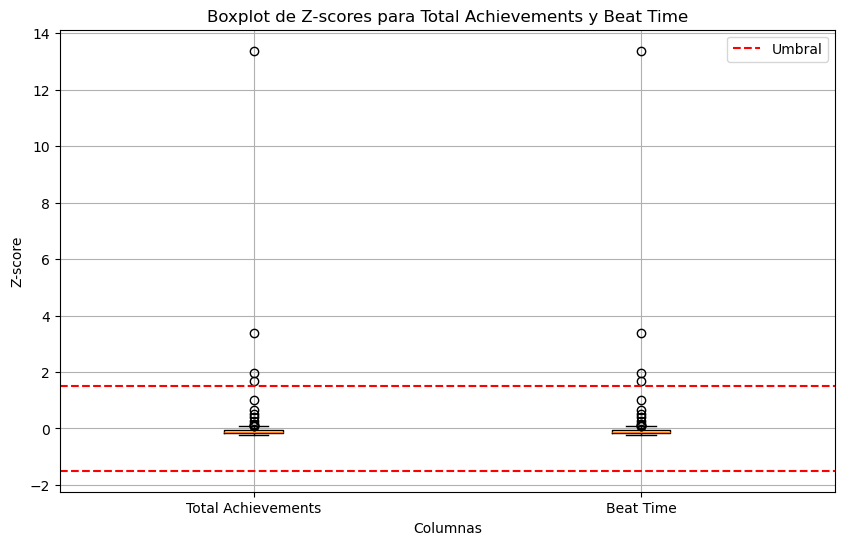

Outliers:
     total_achievements_zscore  beat_time_zscore
31                    3.384932          3.384932
104                   1.946971          1.946971
142                   1.674630          1.674630
229                  13.385300         13.385300


In [48]:

# Crea el boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([z_scores_achievements, z_scores_beat_time], labels=['Total Achievements', 'Beat Time'])
plt.title('Boxplot de Z-scores para Total Achievements y Beat Time')
plt.xlabel('Columnas')
plt.ylabel('Z-score')
plt.grid(True)
plt.axhline(y=threshold, color='r', linestyle='--', label='Umbral')
plt.axhline(y=-threshold, color='r', linestyle='--')
plt.legend()
plt.show()

print("Outliers:")
print(outliers)

## Normalization

In [17]:
# Suponiendo que df_games['total_achievements'] es tu columna que deseas normalizar
total_achievements = df_games[['total_achievements']].values

# Crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Aplica el escalado Min-Max
df_games['total_achievements'] = scaler.fit_transform(total_achievements)

In [18]:
# Suponiendo que df_games['total_achievements'] es tu columna que deseas normalizar
total_achievements = df_games[['beat_time']].values

# Crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Aplica el escalado Min-Max
df_games['beat_time'] = scaler.fit_transform(total_achievements)

<hr>

## Trainning

In [36]:
features = df_games[['total_achievements','beat_time', 'achievement_completed']]
target = df_games['playtime_forever']	


df_games['beat_time'] = pd.to_numeric(df_games['beat_time'], errors='coerce')
df_games['total_achievements'] = pd.to_numeric(df_games['total_achievements'], errors='coerce')

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Inicializa el modelo de regresión lineal
model = LinearRegression()

# Entrena el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Realiza predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

In [37]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 203 entries, 2 to 246
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_achievements     203 non-null    float64
 1   beat_time              203 non-null    float64
 2   achievement_completed  203 non-null    object 
dtypes: float64(2), object(1)
memory usage: 6.3+ KB


<hr>

## Results

In [38]:
# Evalúa el rendimiento del modelo (en este caso, usando el error cuadrático medio)
mse = mean_squared_error(y_test, y_pred)
print(f'Error Cuadrático Medio: {mse}')

Error Cuadrático Medio: 10180615.94540632


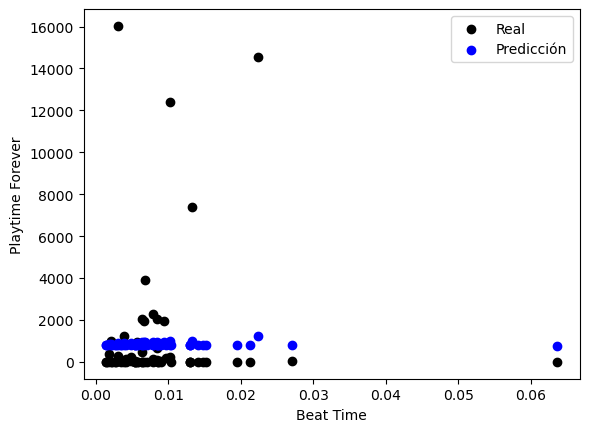

In [39]:
plt.scatter(X_test['beat_time'], y_test, color='black', label='Real')
plt.scatter(X_test['beat_time'], y_pred, color='blue', label='Predicción')
plt.xlabel('Beat Time')
plt.ylabel('Playtime Forever')
plt.legend()
plt.show()

In [40]:
coefficients = model.coef_
intercept = model.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [-509.9886722  -509.9886722     3.88527497]
Intercept: 827.3532424639262


In [41]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate metrics using the test set
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 10180615.94540632
R-squared: 0.023565428285968193
